# Insurance DataViz Project

*By Clara Rohrbasser, Daniel Deutsch and José Lucas Barretto*

In [244]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report

In [5]:
# Matplotlib style
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 7),
    'axes.prop_cycle': plt.cycler(color=['#4C72B0', '#C44E52', '#55A868', '#8172B2', '#CCB974', '#64B5CD']),
    'axes.facecolor': '#EAEAF2'
})

# Data Ingestion

In [6]:
# Import each dataframe
df_claims = pd.read_csv("http://freakonometrics.free.fr/sinistreACT2040.txt", sep=';')
df_contracts = pd.read_csv("http://freakonometrics.free.fr/contractACT2040.txt", sep=';')

# Data Processing

## Claims

In [7]:
# Filters claims 
df_claims = df_claims[df_claims['garantie'] == '1RC'].reset_index(drop=True)

# Obtains the sum and average of costs by contract 
df_claims = df_claims.groupby('nocontrat').agg({'cout': ['sum', 'count']}).droplevel(level=0, axis=1).reset_index()
df_claims.rename(columns={'sum': 'claim_value', 'count': 'n_claims'}, inplace=True)

# Converts dtypes
df_claims = df_claims.apply(pd.to_numeric, errors='ignore')

## Contracts

In [8]:
# Converts dtypes
df_contracts = df_contracts.apply(pd.to_numeric, errors='ignore')

# Drops unused columns
df_contracts = df_contracts.drop('bonus', axis=1)

## Merge Dataframes

In [9]:
df = pd.merge(df_claims, df_contracts, right_on='nocontrat', left_on='nocontrat', how='outer')
df['has_claimed'] = df['n_claims'] > 0
df.fillna({'claim_value': 0, 'n_claims': 0}, inplace=True)

# Data Visualization

## Claims

In [263]:
# Profile of customers that claim
df[df['has_claimed'] == 1].describe()

,nocontrat,claim_value,n_claims,exposition,puissance,agevehicule,ageconducteur,marque,densite,region
count,2.490000e+03,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000
mean,2.233010e+06,1392.938639,1.083133,0.702143,6.481526,7.444980,45.220080,4.610843,51.102811,9.613655
std,1.553072e+06,8636.512505,0.418434,0.308879,2.002173,5.310109,14.428603,4.253796,28.393731,4.791529
min,2.170000e+02,-3738.300000,1.000000,0.005479,4.000000,0.000000,18.000000,1.000000,11.000000,-1.000000
25%,1.076156e+06,0.000000,1.000000,0.450000,5.000000,3.000000,34.000000,1.000000,24.000000,6.000000
50%,2.117496e+06,1034.275000,1.000000,0.780000,6.000000,7.000000,44.000000,2.000000,52.000000,13.000000
75%,3.183329e+06,1204.000000,1.000000,1.000000,7.000000,11.000000,54.000000,6.000000,82.000000,13.000000
max,6.111650e+06,382955.140000,16.000000,1.050000,15.000000,69.000000,91.000000,14.000000,94.000000,13.000000


In [264]:
# Profile of customers that dont claim
df[df['has_claimed'] == 0].describe()

,nocontrat,claim_value,n_claims,exposition,puissance,agevehicule,ageconducteur,marque,densite,region
count,4.751000e+04,47510.0,47510.0,47510.000000,47510.000000,47510.000000,47510.000000,47510.000000,47510.000000,47510.000000
mean,2.652039e+06,0.0,0.0,0.519528,6.457904,7.053673,45.563376,5.416102,51.169522,10.278510
std,1.644695e+06,0.0,0.0,0.364350,2.060685,5.702152,14.079063,4.643617,29.513101,4.188543
min,2.700000e+01,0.0,0.0,0.002732,4.000000,0.000000,18.000000,1.000000,11.000000,-1.000000
25%,1.167396e+06,0.0,0.0,0.160000,5.000000,2.000000,35.000000,2.000000,24.000000,8.000000
50%,2.276102e+06,0.0,0.0,0.490000,6.000000,6.000000,44.000000,3.000000,52.000000,13.000000
75%,4.057991e+06,0.0,0.0,0.960000,7.000000,11.000000,55.000000,12.000000,82.000000,13.000000
max,6.114310e+06,0.0,0.0,1.740000,15.000000,100.000000,100.000000,14.000000,94.000000,13.000000


### Claim Value Distribution

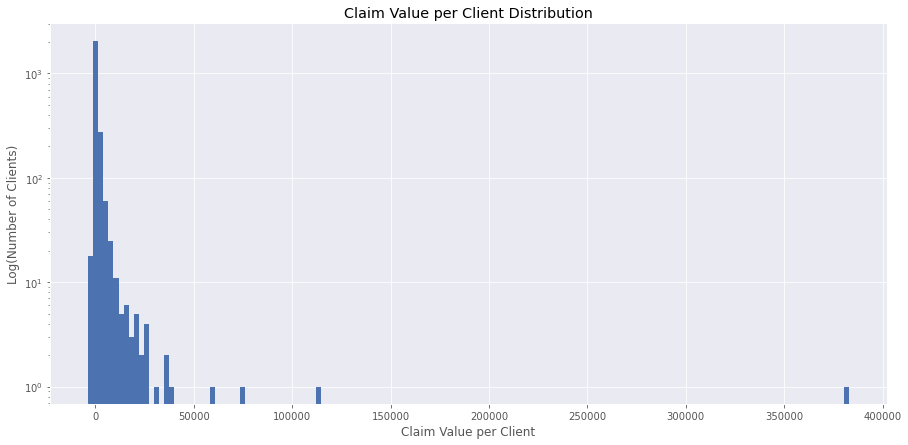

In [10]:
df_claims.hist('claim_value', log=True, bins=150)
plt.title("Claim Value per Client Distribution")
plt.ylabel("Log(Number of Clients)")
plt.xlabel("Claim Value per Client")
plt.show()

### Number of Claims per Client

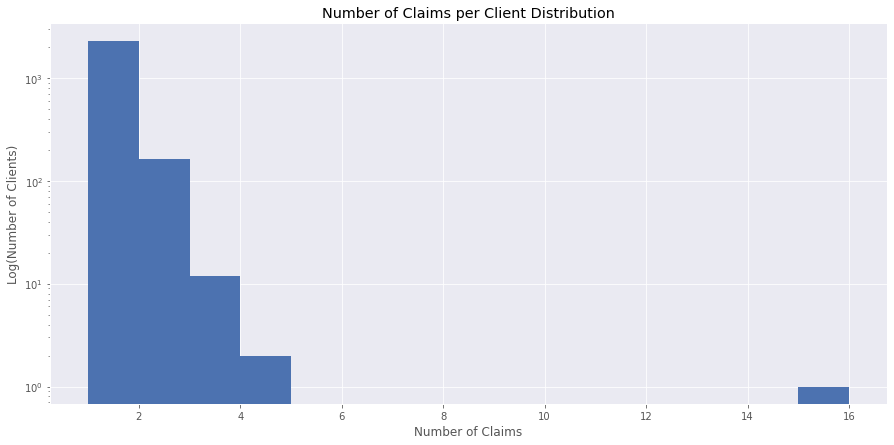

In [11]:
df_claims.hist('n_claims', log=True, bins=15)
plt.title("Number of Claims per Client Distribution")
plt.ylabel("Log(Number of Clients)")
plt.xlabel("Number of Claims")
plt.show()

## Contracts

### Correlation Matrix of the Contracts Features

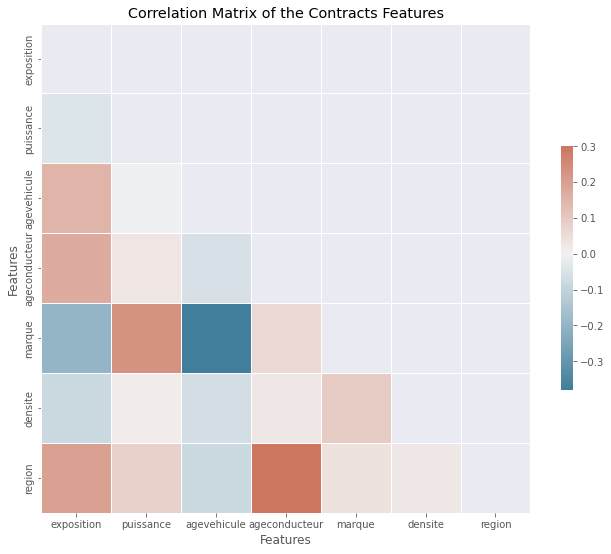

In [12]:
# Compute the correlation matrix
corr = df_contracts.drop(columns=['nocontrat']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix of the Contracts Features")
plt.ylabel("Features")
plt.xlabel("Features")
plt.show()

## Full Dataframe

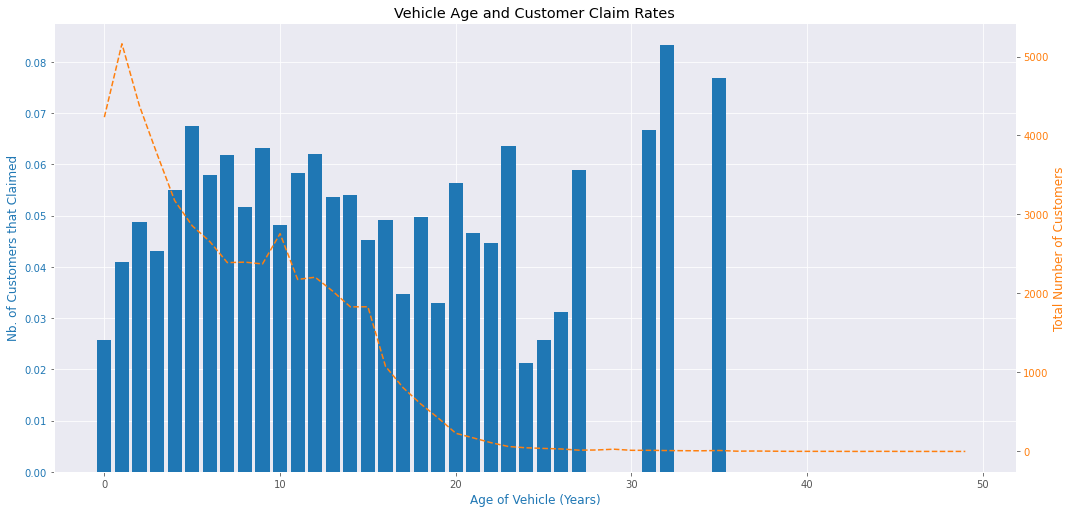

In [27]:
claim_rate = df.groupby('agevehicule')['has_claimed'].agg(['sum', 'count']).reset_index()
claim_rate['pct_claimed'] = claim_rate['sum']/claim_rate['count']
claim_rate = claim_rate[claim_rate['agevehicule'] < 50]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Nb. of Customers that Claimed', color=color)
ax1.set_xlabel('Age of Vehicle (Years)', color=color)
ax1.bar(claim_rate['agevehicule'], claim_rate['pct_claimed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Total Number of Customers', color=color)  # we already handled the x-label with ax1
ax2.plot(claim_rate['agevehicule'], claim_rate['count'], '--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Vehicle Age and Customer Claim Rates')
plt.show()


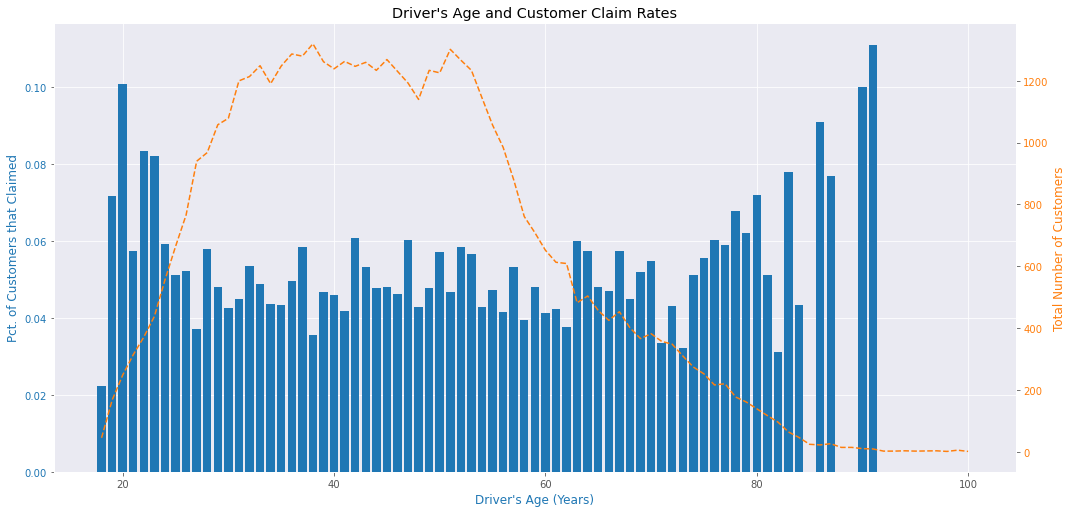

In [28]:
claim_rate = df.groupby('ageconducteur')['has_claimed'].agg(['sum', 'count']).reset_index()
claim_rate['pct_claimed'] = claim_rate['sum']/claim_rate['count']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Pct. of Customers that Claimed', color=color)
ax1.set_xlabel('Driver\'s Age (Years)', color=color)
ax1.bar(claim_rate['ageconducteur'], claim_rate['pct_claimed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Total Number of Customers', color=color)  # we already handled the x-label with ax1
ax2.plot(claim_rate['ageconducteur'], claim_rate['count'], '--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Driver\'s Age and Customer Claim Rates')
plt.show()

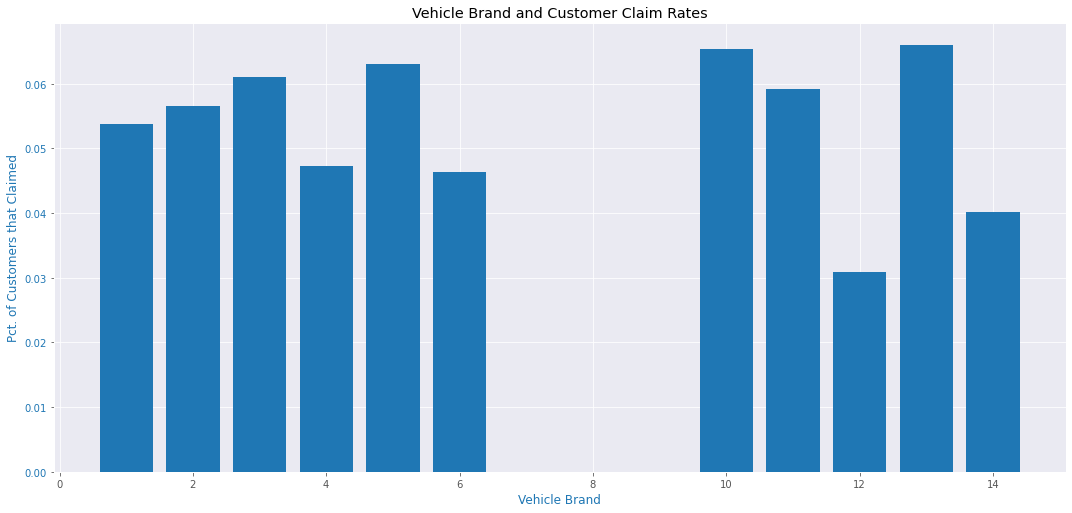

In [39]:
claim_rate = df.groupby('marque')['has_claimed'].agg(['sum', 'count']).reset_index()
claim_rate['pct_claimed'] = claim_rate['sum']/claim_rate['count']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Pct. of Customers that Claimed', color=color)
ax1.set_xlabel('Vehicle Brand', color=color)
ax1.bar(claim_rate['marque'], claim_rate['pct_claimed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Vehicle Brand and Customer Claim Rates')
plt.show()

In [38]:
claim_rate

,carburant,sum,count,pct_claimed
0,D,1262,24413,0.051694
1,E,1228,25587,0.047993


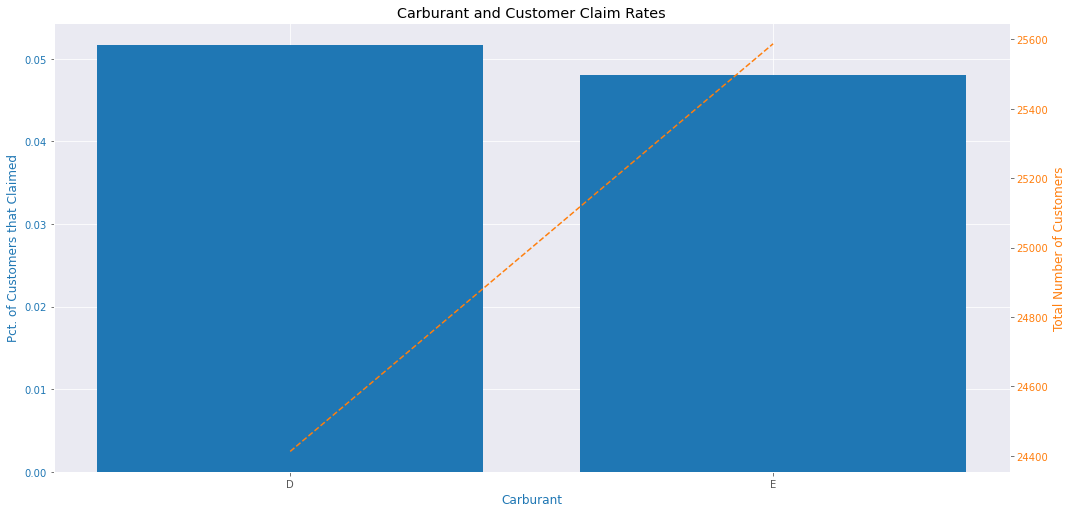

In [36]:
claim_rate = df.groupby('carburant')['has_claimed'].agg(['sum', 'count']).reset_index()
claim_rate['pct_claimed'] = claim_rate['sum']/claim_rate['count']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Pct. of Customers that Claimed', color=color)
ax1.set_xlabel('Carburant', color=color)
ax1.bar(claim_rate['carburant'], claim_rate['pct_claimed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Total Number of Customers', color=color)  # we already handled the x-label with ax1
ax2.plot(claim_rate['carburant'], claim_rate['count'], '--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Carburant and Customer Claim Rates')
plt.show()

In [37]:
claim_rate

,carburant,sum,count,pct_claimed
0,D,1262,24413,0.051694
1,E,1228,25587,0.047993


In [ ]:
claim_rate = df.groupby('marque')['has_claimed'].agg(['sum', 'count']).reset_index()
claim_rate['pct_claimed'] = claim_rate['sum']/claim_rate['count']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Pct. of Customers that Claimed', color=color)
ax1.set_xlabel('Vehicle Brand', color=color)
ax1.bar(claim_rate['marque'], claim_rate['pct_claimed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Total Number of Customers', color=color)  # we already handled the x-label with ax1
ax2.plot(claim_rate['marque'], claim_rate['count'], '--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Vehicle Brand and Customer Claim Rates')
plt.show()

# Models

## Claim probability

In [256]:
categorical = ['zone', 'marque', 'carburant', 'region']
numerical = ['puissance', 'exposition', 'agevehicule', 'ageconducteur']

# select endogenous and exogenous variables
X = df[categorical + numerical]
y = df['has_claimed']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# initialize encoder for categorical vars
enc = OneHotEncoder(drop='first', sparse=False)

# fit transform encoder to train data
X_train_categorical = pd.DataFrame(enc.fit_transform(X_train[categorical]), index=X_train.index, columns=enc.get_feature_names_out())

# transform encoder to test data
X_test_categorical = pd.DataFrame(enc.transform(X_test[categorical]), index=X_test.index, columns=enc.get_feature_names_out())

# initialize scaler for numerical vars
scaler = StandardScaler()

# fit transform scaler to train data
X_train_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical]), index=X_train.index, columns=numerical)

# transform scaler to test data
X_test_numerical = pd.DataFrame(scaler.transform(X_test[numerical]), index=X_test.index, columns=numerical)

# concatenate numerical and categorical vars
X_train_normal = pd.concat((X_train_numerical, X_train_categorical), axis=1)
X_test_normal = pd.concat((X_test_numerical, X_test_categorical), axis=1)

In [257]:
# train model
clf = LogisticRegressionCV(cv=3, penalty='l1', scoring='roc_auc', class_weight='balanced', solver='liblinear').fit(X_train_normal, y_train)

# print classification report
print(classification_report(y_train, clf.predict(X_train_normal), zero_division=0))

              precision    recall  f1-score   support

       False       0.97      0.59      0.74     33287
        True       0.08      0.66      0.14      1713

    accuracy                           0.60     35000
   macro avg       0.52      0.63      0.44     35000
weighted avg       0.93      0.60      0.71     35000



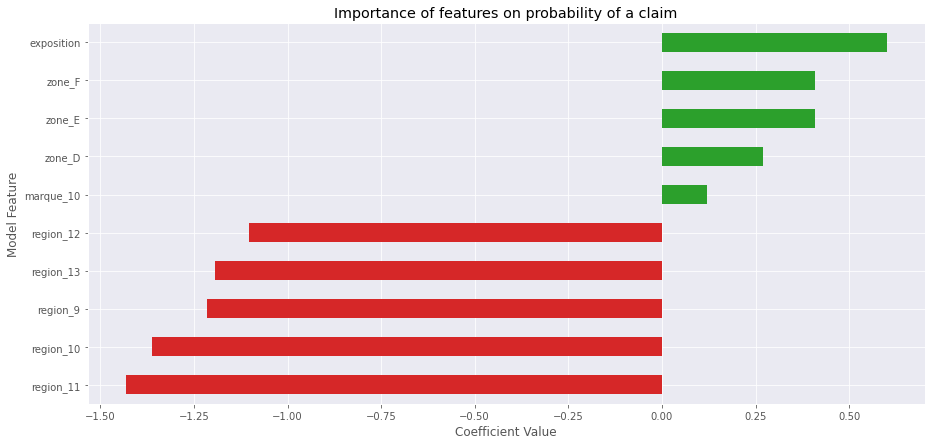

In [258]:
plt.figure()
coefs = pd.DataFrame(clf.coef_, columns=X_train_normal.columns).T
coefs.columns = ['coefficient']
coefs['positive'] = coefs['coefficient'] > 0
coefs.sort_values('coefficient', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['coefficient'].plot(kind='barh', color=coefs.positive.map({True: 'tab:green', False: 'tab:red'}))

plt.xlabel('Coefficient Value')
plt.ylabel('Model Feature')
plt.title('Importance of features on probability of a claim')
plt.show()

### Claim value

In [259]:
categorical = ['zone', 'marque', 'carburant', 'region']
numerical = ['puissance', 'exposition', 'agevehicule', 'ageconducteur']

# select endogenous and exogenous variables
X = df[categorical + numerical]
y = df[['claim_value']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# initialize encoder for categorical vars
enc = OneHotEncoder(drop='first', sparse=False)

# fit transform encoder to train data
X_train_categorical = pd.DataFrame(enc.fit_transform(X_train[categorical]), index=X_train.index, columns=enc.get_feature_names_out())

# transform encoder to test data
X_test_categorical = pd.DataFrame(enc.transform(X_test[categorical]), index=X_test.index, columns=enc.get_feature_names_out())

# initialize scaler for numerical vars
scaler_x = StandardScaler()

# fit transform scaler to train data
X_train_numerical = pd.DataFrame(scaler_x.fit_transform(X_train[numerical]), index=X_train.index, columns=numerical)

# transform scaler to test data
X_test_numerical = pd.DataFrame(scaler_x.transform(X_test[numerical]), index=X_test.index, columns=numerical)

# concatenate numerical and categorical vars
X_train_normal = pd.concat((X_train_numerical, X_train_categorical), axis=1)
X_test_normal = pd.concat((X_test_numerical, X_test_categorical), axis=1)

# train model
model = RidgeCV(cv=5).fit(X_train_normal, y_train)

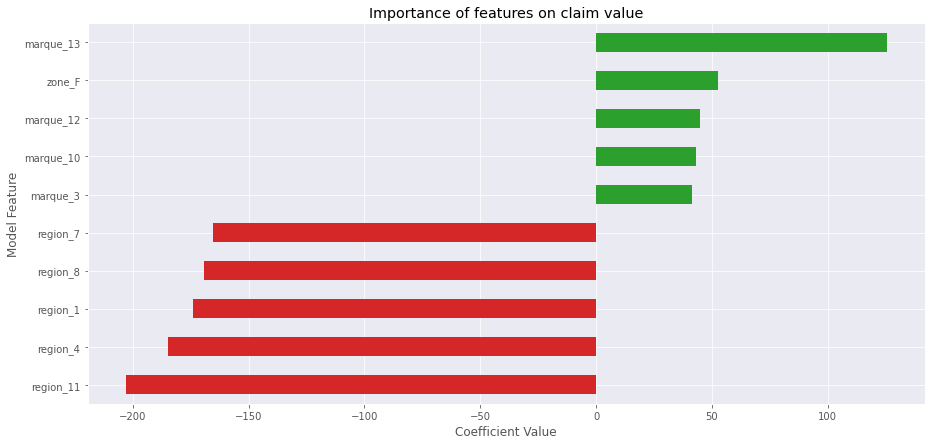

In [260]:
plt.figure()
coefs = pd.DataFrame(model.coef_.T, index=X_train_normal.columns, columns=['coefficient'])
coefs['positive'] = coefs['coefficient'] > 0
coefs.sort_values('coefficient', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['coefficient'].plot(kind='barh', color=coefs.positive.map({True: 'tab:green', False: 'tab:red'}))

plt.xlabel('Coefficient Value')
plt.ylabel('Model Feature')
plt.title('Importance of features on claim value')
plt.show()